In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
from sklearn.utils import shuffle

In [2]:
# signal
s0 = pd.read_csv ( "signal.csv" )
s1 = pd.read_csv ( "0.csv" )
s2 = pd.read_csv ( "30.csv" )
s3 = pd.read_csv ( "60.csv" )

# bkg
b1 = pd.read_csv ( "sideband.csv" )
b2 = pd.read_csv ( "nearsignal.csv" )

In [3]:
# total bkg
b = pd.concat([b1,b2])
b = shuffle(b,random_state=42).reset_index(drop=True)
b.head()

,phib,phif,phitstar,phiw,t,thetab,thetaf,thetah,thetat,thetaw,tt,tth,isSignal
0,2.920753,1.090986,1.733981,0.137239,268.494580,0.653567,0.682121,0.917943,0.971721,0.566443,1268.745280,1430.672788,0
1,2.835025,1.946042,1.402751,2.896944,201.750574,0.781232,-0.180910,-0.915062,0.501745,0.743011,716.177864,923.922878,0
2,2.973645,2.530269,1.016207,1.918484,291.116294,0.412756,-0.916697,-0.677089,0.732552,0.761561,673.165946,807.950518,0
3,1.654473,1.665302,2.096471,0.131641,315.002068,0.144500,-0.940423,0.789105,0.133557,0.407656,837.942784,977.678059,0
4,2.122228,1.143082,0.394234,0.968614,235.680119,0.006688,0.710969,-0.932373,0.739628,0.535162,523.067557,702.426124,0


In [4]:
c0 = ['phib', 'phif', 'phitstar', 'phiw', 't', 'thetab', 'thetaf', 'thetah','thetat', 'thetaw', 'tt', 'tth']

In [5]:
from sklearn import model_selection , preprocessing

In [6]:
import tensorflow as tf
tf.random.set_random_seed(123)

In [7]:
# dftrain, dfeval, y_train, y_eval 
def preprocess(s, b):
    # sample signal
    S0 = s.sample(b.shape[0], random_state=42)

    # training dataset
    train0 = pd.concat([S0,b])

    # Shuffle training dataset
    train0 = shuffle(train0,random_state=42).reset_index(drop=True)
    
    # Standardize
    sc0 = preprocessing . StandardScaler ()
    input_data0 = sc0 . fit_transform ( train0[c0[0:12]] )
    target0 = train0['isSignal']

    # set random seed
    Answer_to_all_questions = 42
    # train - test split of dataset
    train_data0 , test_data0 , train_target0 , test_target0 = model_selection . train_test_split (\
    input_data0 , target0 , test_size =0.3 , random_state = Answer_to_all_questions )
    
    # back to df
    train = pd.DataFrame({'phib': train_data0[:, 0], 'phif': train_data0[:, 1],'phitstar': train_data0[:, 2],
                      'phiw': train_data0[:, 3],'t': train_data0[:, 4], 'thetab': train_data0[:, 5],
                      'thetaf': train_data0[:, 6],'thetah': train_data0[:, 7], 'thetat': train_data0[:, 8],
                      'thetaw': train_data0[:, 9],'tt': train_data0[:, 10],'tth': train_data0[:, 11], 
                      'isSignal': train_target0})
    
    val = pd.DataFrame({'phib': test_data0[:, 0], 'phif': test_data0[:, 1],'phitstar': test_data0[:, 2],
                      'phiw': test_data0[:, 3],'t': test_data0[:, 4], 'thetab': test_data0[:, 5],
                      'thetaf': test_data0[:, 6],'thetah': test_data0[:, 7], 'thetat': test_data0[:, 8],
                      'thetaw': test_data0[:, 9],'tt': test_data0[:, 10],'tth': test_data0[:, 11], 
                      'isSignal': test_target0})
    
    
    return train[c0], val[c0], train.pop('isSignal'), val.pop('isSignal')

## signal vs. bkg

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [9]:
# dftrain, dfeval, y_train, y_eval 
X0,x0,Y0,y0 = preprocess(s0,b)

In [10]:
fc = tf.feature_column
feature_columns = []

for feature_name in c0:
  feature_columns.append(fc.numeric_column(feature_name,dtype=tf.float32))

In [11]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(Y0)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES))
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(X0, Y0)
eval_input_fn = make_input_fn(x0, y0, shuffle=False, n_epochs=1)

In [12]:
params = {
  'n_trees': 50,
  'max_depth': 10,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'learning_rate' : 0.01,
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.600690
accuracy_baseline,0.506903
auc,0.632477
auc_precision_recall,0.619727
average_loss,0.676258
label/mean,0.506903
loss,0.676258
precision,0.600056
prediction/mean,0.496954
recall,0.636471


In [13]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\11045\\AppData\\Local\\Temp\\tmpg1go6z61', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000018FCC0809C8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph 

In [14]:
# Create DFC Pandas dataframe.
labels = y0.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
tth,6664.0,0.001118,0.008840,-0.037026,-0.004939,0.001589,0.007805,0.025996
thetah,6664.0,0.000557,0.005952,-0.038314,-0.003373,0.002829,0.004355,0.019298
tt,6664.0,0.000718,0.007014,-0.035985,-0.004162,0.000772,0.005445,0.021448
thetaw,6664.0,-0.000467,0.004174,-0.033053,-0.001928,0.000114,0.001673,0.024013
phiw,6664.0,-0.000476,0.004340,-0.043253,-0.001457,0.000000,0.001482,0.017994
thetaf,6664.0,-0.000850,0.005655,-0.051054,-0.003279,0.000952,0.002758,0.014375
thetat,6664.0,-0.000571,0.004513,-0.034503,-0.001646,-0.000040,0.001130,0.017952
phib,6664.0,-0.000282,0.005480,-0.090429,-0.000950,0.000000,0.001445,0.043970
thetab,6664.0,-0.000027,0.004360,-0.026929,-0.002239,0.000425,0.001876,0.021503
phitstar,6664.0,-0.001031,0.004291,-0.040605,-0.001874,0.000000,0.000411,0.016088


In [15]:
# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

In [16]:
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example,dfeval):
  TOP_N = 12 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(12,10))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
  return ax

## local feature importance

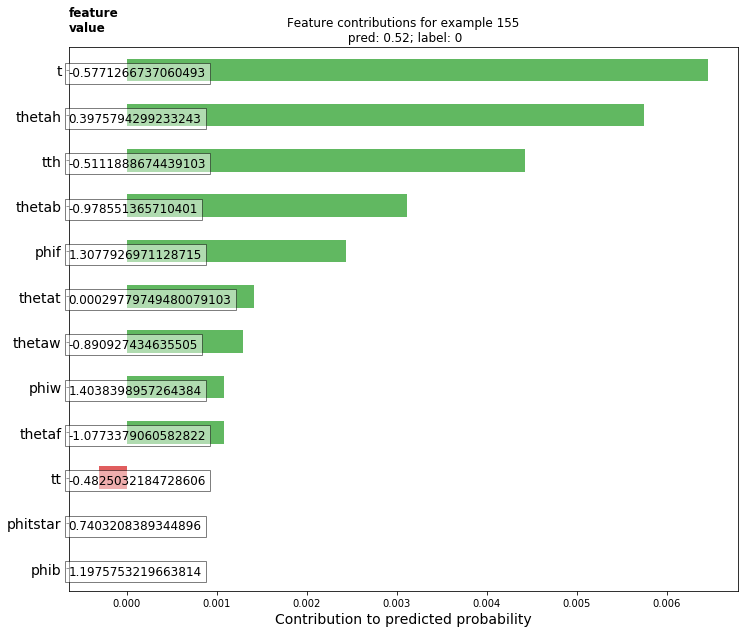

In [17]:
# Plot results.
ID = 155
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 12
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example,x0)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

## Global feature importances

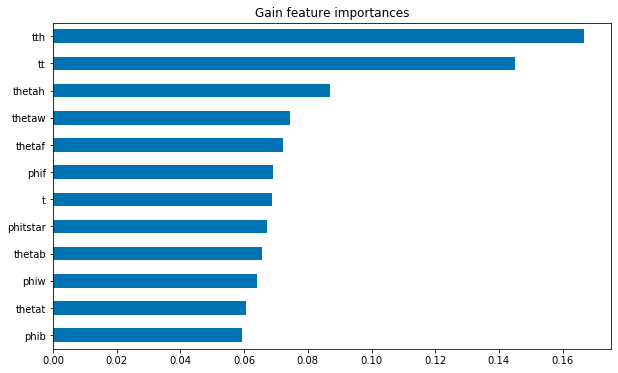

In [18]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:12][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

## cp0 vs. bkg

In [19]:
# dftrain, dfeval, y_train, y_eval 
X0,x0,Y0,y0 = preprocess(s1,b)

In [20]:
# Training and evaluation input functions.
train_input_fn = make_input_fn(X0, Y0)
eval_input_fn = make_input_fn(x0, y0, shuffle=False, n_epochs=1)

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.601891
accuracy_baseline,0.506903
auc,0.630585
auc_precision_recall,0.619270
average_loss,0.674880
label/mean,0.506903
loss,0.674880
precision,0.598318
prediction/mean,0.496192
recall,0.653049


In [21]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

# Create DFC Pandas dataframe.
labels = y0.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\11045\\AppData\\Local\\Temp\\tmprkxvacqk', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000018FD3FFB588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph 

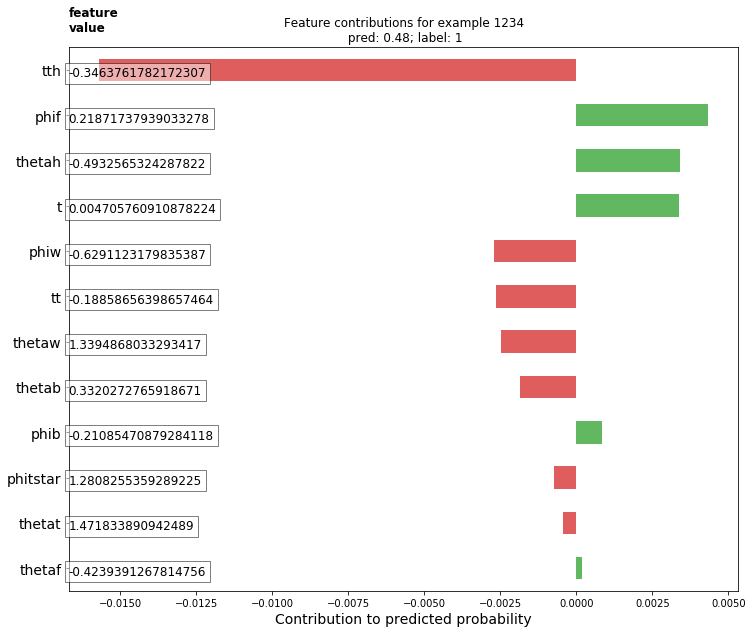

In [22]:
# Plot results.
ID = 1234
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 12
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example,x0)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

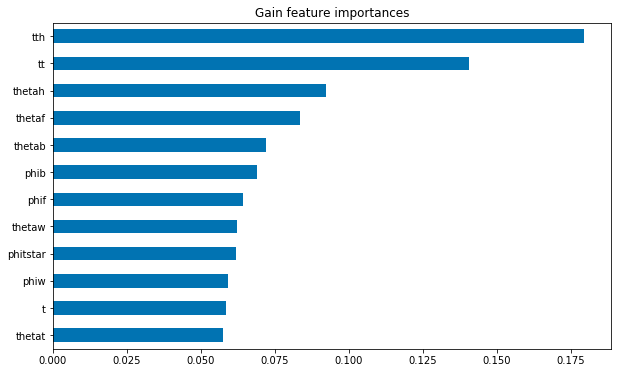

In [23]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:12][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

## cp30 vs. bkg

In [24]:
# dftrain, dfeval, y_train, y_eval 
X0,x0,Y0,y0 = preprocess(s2,b)

# Training and evaluation input functions.
train_input_fn = make_input_fn(X0, Y0)
eval_input_fn = make_input_fn(x0, y0, shuffle=False, n_epochs=1)

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.594238
accuracy_baseline,0.506903
auc,0.625157
auc_precision_recall,0.610385
average_loss,0.676499
label/mean,0.506903
loss,0.676499
precision,0.584759
prediction/mean,0.496802
recall,0.688277


In [25]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

# Create DFC Pandas dataframe.
labels = y0.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\11045\\AppData\\Local\\Temp\\tmpwssw9j6_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000018FCC4B5448>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph 

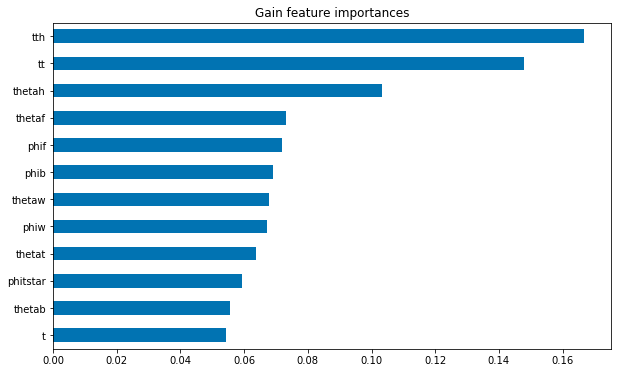

In [26]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:12][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

## cp60 vs. bkg

In [27]:
# dftrain, dfeval, y_train, y_eval 
X0,x0,Y0,y0 = preprocess(s3,b)

# Training and evaluation input functions.
train_input_fn = make_input_fn(X0, Y0)
eval_input_fn = make_input_fn(x0, y0, shuffle=False, n_epochs=1)

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.638956
accuracy_baseline,0.506903
auc,0.696679
auc_precision_recall,0.686862
average_loss,0.652846
label/mean,0.506903
loss,0.652846
precision,0.639255
prediction/mean,0.496245
recall,0.660450


In [28]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

# Create DFC Pandas dataframe.
labels = y0.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\11045\\AppData\\Local\\Temp\\tmpp0krmj99', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000018FD4C8D3C8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph 

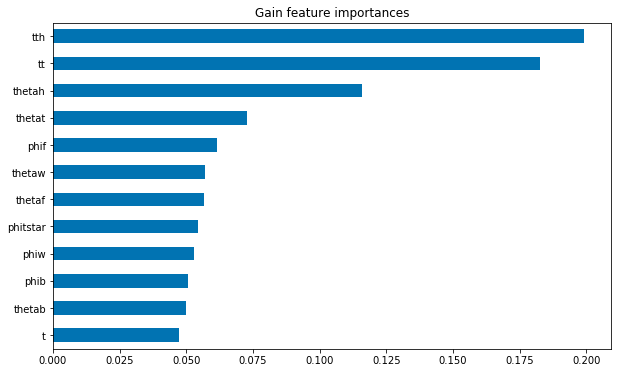

In [29]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:12][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

## cp0 vs. cp30 vs. cp60

---

For now only binary classification is supported in tensorflow so there will be 3 seperate models

In [40]:
# dftrain, dfeval, y_train, y_eval 
def cp(a,b):
    
    a.insert(13,'alpha',0)
    b = b.sample(a.shape[0], random_state=42)
    b.insert(13,'alpha',1)
    
    # training dataset
    train0 = pd.concat([a,b])

    # Shuffle training dataset
    train0 = shuffle(train0,random_state=42).reset_index(drop=True)
    
    # Standardize
    sc0 = preprocessing . StandardScaler ()
    input_data0 = sc0 . fit_transform ( train0[c0[0:12]] )
    target0 = train0['alpha']

    # set random seed
    Answer_to_all_questions = 42
    # train - test split of dataset
    train_data0 , test_data0 , train_target0 , test_target0 = model_selection . train_test_split (\
    input_data0 , target0 , test_size =0.3 , random_state = Answer_to_all_questions )
    
    # back to df
    train = pd.DataFrame({'phib': train_data0[:, 0], 'phif': train_data0[:, 1],'phitstar': train_data0[:, 2],
                      'phiw': train_data0[:, 3],'t': train_data0[:, 4], 'thetab': train_data0[:, 5],
                      'thetaf': train_data0[:, 6],'thetah': train_data0[:, 7], 'thetat': train_data0[:, 8],
                      'thetaw': train_data0[:, 9],'tt': train_data0[:, 10],'tth': train_data0[:, 11], 
                      'alpha': train_target0})
    
    val = pd.DataFrame({'phib': test_data0[:, 0], 'phif': test_data0[:, 1],'phitstar': test_data0[:, 2],
                      'phiw': test_data0[:, 3],'t': test_data0[:, 4], 'thetab': test_data0[:, 5],
                      'thetaf': test_data0[:, 6],'thetah': test_data0[:, 7], 'thetat': test_data0[:, 8],
                      'thetaw': test_data0[:, 9],'tt': test_data0[:, 10],'tth': test_data0[:, 11], 
                      'alpha': test_target0})
    
    
    return train[c0], val[c0], train.pop('alpha'), val.pop('alpha')

In [41]:
# dftrain, dfeval, y_train, y_eval 
X0,x0,Y0,y0 = cp(s1,s2)
NUM_EXAMPLES = 200
# Training and evaluation input functions.
train_input_fn = make_input_fn(X0, Y0)
eval_input_fn = make_input_fn(x0, y0, shuffle=False, n_epochs=1)

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.503456
accuracy_baseline,0.503237
auc,0.505158
auc_precision_recall,0.506660
average_loss,0.694583
label/mean,0.503237
loss,0.694540
precision,0.507879
prediction/mean,0.494169
recall,0.428634


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\11045\\AppData\\Local\\Temp\\tmphdse5i1m', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000018FCC585388>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph 

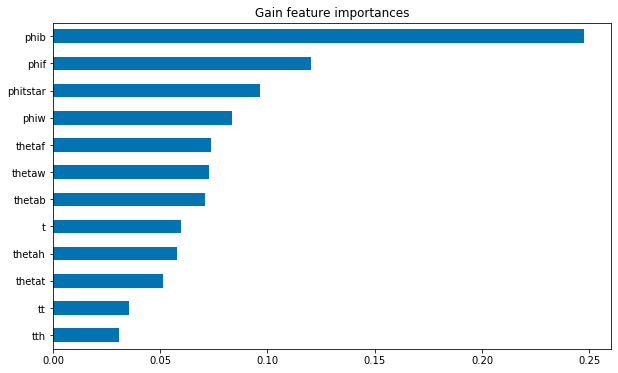

In [42]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

# Create DFC Pandas dataframe.
labels = y0.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:12][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

In [43]:
s1 = pd.read_csv ( "0.csv" )
s2 = pd.read_csv ( "30.csv" )
s3 = pd.read_csv ( "60.csv" )

# dftrain, dfeval, y_train, y_eval 
X0,x0,Y0,y0 = cp(s1,s3)
NUM_EXAMPLES = 200
# Training and evaluation input functions.
train_input_fn = make_input_fn(X0, Y0)
eval_input_fn = make_input_fn(x0, y0, shuffle=False, n_epochs=1)

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.532065
accuracy_baseline,0.503237
auc,0.543742
auc_precision_recall,0.543196
average_loss,0.690516
label/mean,0.503237
loss,0.690526
precision,0.546035
prediction/mean,0.491277
recall,0.416029


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\11045\\AppData\\Local\\Temp\\tmp68c678le', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000018FDA74CFC8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph 

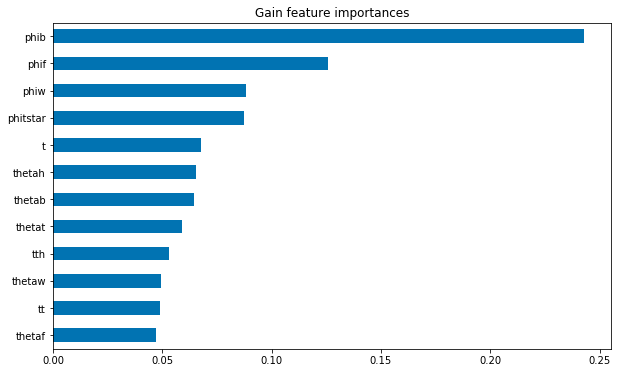

In [44]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

# Create DFC Pandas dataframe.
labels = y0.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:12][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

In [45]:
s1 = pd.read_csv ( "0.csv" )
s2 = pd.read_csv ( "30.csv" )
s3 = pd.read_csv ( "60.csv" )

# dftrain, dfeval, y_train, y_eval 
X0,x0,Y0,y0 = cp(s3,s2)
NUM_EXAMPLES = 200
# Training and evaluation input functions.
train_input_fn = make_input_fn(X0, Y0)
eval_input_fn = make_input_fn(x0, y0, shuffle=False, n_epochs=1)

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.514885
accuracy_baseline,0.500610
auc,0.521976
auc_precision_recall,0.520927
average_loss,0.693465
label/mean,0.500610
loss,0.693591
precision,0.524712
prediction/mean,0.482698
recall,0.328597


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\11045\\AppData\\Local\\Temp\\tmp4i4gmeee', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000018FD470DEC8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph 

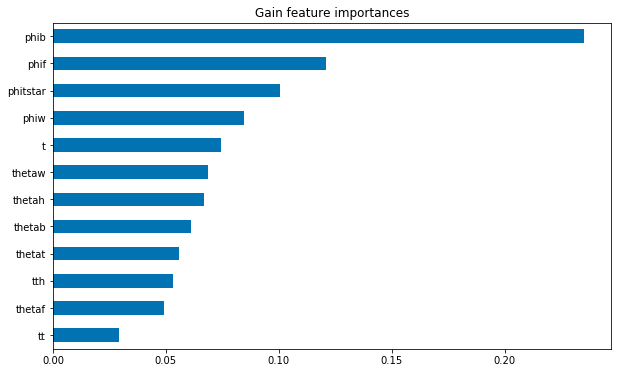

In [46]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

# Create DFC Pandas dataframe.
labels = y0.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:12][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')